# (Try to) identify signals of gentrification from Airbnb data

In [1]:
import os
import re

import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from scipy.stats import zscore, gaussian_kde
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import numpy as np

from datetime import datetime

import seaborn as sns

from shapely.geometry import Point
from geopandas import GeoDataFrame

from IPython.core.pylabtools import figsize
from fontTools.varLib.interpolatableHelpers import matching_for_vectors
#from pygments.lexers.textfmts import TodotxtLexer
from together import Together  # pip install together

# from statsmodels.stats.inter_rater import fleiss_kappa

from Functions import *

In [39]:
def plot_rose(ax, indicators, lsoa_code, color):
    this_lsoa = indicators[indicators['LSOA11CD'] == lsoa_code]
    this_lsoa.reset_index(inplace=True, drop=True)
    del this_lsoa['LSOA11CD']
    del this_lsoa['LA_NAME']
    del this_lsoa['gentrification_prediction_code']
    this_lsoa_T = this_lsoa.T
    this_lsoa_T.reset_index(inplace=True)
    this_lsoa_T = this_lsoa_T.rename(columns={0: 'scores'})
    # E01014485_T['max_vals'] = max_vals[0].values
    df = this_lsoa_T.copy()
    # df['pct'] = df['scores'] / df['max_vals']
    df = df.set_index('index')
    
    # Replace NaN values with 0 in the plot data (but keep NaNs in the DataFrame)
    df['scores_for_plot'] = df['scores'].fillna(0)
    
    # Recalculate N and angles after replacing NaNs
    N = df.shape[0]
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
    
    # Assign new angles
    df['radar_angles'] = theta
    
    # Plot
    ax.bar(df['radar_angles'], df['scores_for_plot'], width=2 * np.pi / N, linewidth=2, edgecolor='k', alpha=0.6, color=color)
    
    # Adjust labels (keeping original categories with NaNs)
    ax.set_xticks(theta)
    ax.set_xticklabels(df.index)
    ax.set_yticklabels([])

### Running for Bristol 

For Bristol there should be 1495 rows in the results. There are 2644 rows in the original listings file, but 1149 of them have no description for the neighbourhood overview or 

In [3]:
city='bristol'
neighbourhoods = gpd.read_file(f"../data/airbnb-{city}/neighbourhoods.geojson")
lsoas =  gpd.read_file('../data/Bristol_LSOAs/Lower_Layer_Super_Output_Areas_2011_(Precise).shp')

In [4]:
base_dir = os.path.expanduser(f"../data/airbnb-{city}/")
gentrication_cat_df = pd.read_csv(base_dir + 'airbnb_gentrification_scores_categorical_01.csv')
gentrication_df = pd.read_csv(base_dir + 'airbnb_gentrification_scores_newprompt_completelistings_01.csv')
niceness_df = pd.read_csv(base_dir + 'airbnb_gentrification_scores_niceness_completelistings_01.csv')

In [5]:
overall_df = gentrication_cat_df
overall_df['niceness_score'] = niceness_df['gentrification_prediction']
overall_df['niceness_explanation'] = niceness_df['explanation']
overall_df['gentrification_num_score'] = gentrication_df['gentrification_prediction']
overall_df['gentrification_num_explanation'] = gentrication_df['explanation']

In [6]:
# 1. Create a GeoDataFrame from your overall_df (assumed to be in WGS84)
overall_df['geometry'] = overall_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
overall_gdf = gpd.GeoDataFrame(overall_df, geometry='geometry', crs="EPSG:4326")

# 2. Reproject the overall_gdf to match the LSOA CRS (for example, British National Grid EPSG:27700)
overall_gdf = overall_gdf.to_crs(lsoas.crs)

# 3. Perform a spatial join (using the 'within' predicate) to find which LSOA each point falls into.
# Replace 'LSOA_NAME' with the name of the column in lsoa_gdf that contains the LSOA identifier.
overall_gdf = gpd.sjoin(overall_gdf, lsoas[['LSOA11NM', 'geometry']], how='left', predicate='within')

### Remove:
- NaN values

In [7]:
# print(len(df))
# df = df[df['gentrification_prediction'].notna()].copy()
# print(len(df))

### Add:
- Column for the length of the text given to the model
- Column for the relative price of the listing

In [8]:
overall_gdf['overview_length'] = overall_gdf['text'].apply(lambda x: len(str(x)) if x else 0)
overall_gdf = add_relative_price(overall_gdf)
# df['room_type_code'] = pd.factorize(df['room_type'])[0] + 1

In [9]:
mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
overall_gdf['gentrification_prediction_code'] = overall_gdf['gentrification_prediction'].map(mapping)

In [10]:
# neighbourhoods_scores_gentrification = overall_gdf.groupby("LSOA11NM")["gentrification_prediction_code"].agg(lambda x: pd.Series.mode(x).tolist())
# neighbourhoods_scores_num_gentrification = overall_gdf.groupby("LSOA11NM")["gentrification_num_score"].agg(lambda x: pd.Series.mode(x).tolist())
# neighbourhoods_scores_niceness = overall_gdf.groupby("LSOA11NM")["niceness_score"].agg(lambda x: pd.Series.mode(x).tolist())

neighbourhoods_scores_gentrification = overall_gdf.groupby("LSOA11NM")["gentrification_prediction_code"].agg(lambda x: pd.Series.mode(x).iloc[0])
neighbourhoods_scores_num_gentrification = overall_gdf.groupby("LSOA11NM")["gentrification_num_score"].agg(
    lambda x: pd.Series.mode(x).iloc[0] if not pd.Series.mode(x).empty else np.nan)
neighbourhoods_scores_niceness = overall_gdf.groupby("LSOA11NM")["niceness_score"].agg(
    lambda x: pd.Series.mode(x).iloc[0] if not pd.Series.mode(x).empty else np.nan)

count = overall_gdf.groupby("LSOA11NM")["gentrification_prediction_code"].count()
count.name = 'Count'
# neighbourhoods = neighbourhoods.sort_values(by='neighbourhood')
# neighbourhoods['gentrification_prediction'] = np.array(neighbourhoods_scores_gentrification)
# neighbourhoods['niceness_score'] = np.array(neighbourhoods_scores_niceness)
# neighbourhoods['gentrification_num_prediction'] = np.array(neighbourhoods_scores_num_gentrification

lsoas = lsoas.sort_values(by='LSOA11NM')

lsoas = lsoas.merge(neighbourhoods_scores_gentrification, on='LSOA11NM', how='left')
lsoas = lsoas.merge(neighbourhoods_scores_niceness, on='LSOA11NM', how='left')
lsoas = lsoas.merge(neighbourhoods_scores_num_gentrification, on='LSOA11NM', how='left')
lsoas = lsoas.merge(count, on='LSOA11NM', how='left')

lsoas['gentrification_prediction_code'] = lsoas['gentrification_prediction_code'].fillna(0)

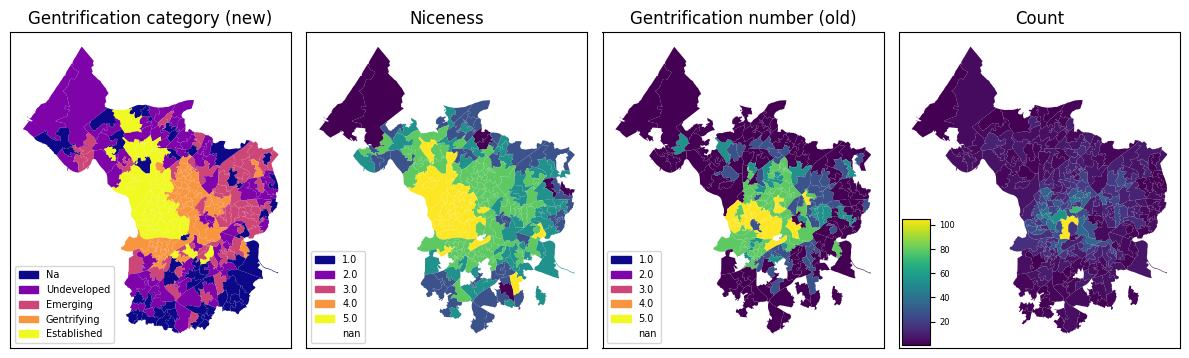

In [219]:
fig, axs = plt.subplots(ncols=4, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1, 1, 1]})  # Ensure equal subplot sizes

cmap = plt.get_cmap('plasma')

# ---- PLOT 1: CATEGORICAL GENTRIFICATION ----
lsoas.plot(ax=axs[0], column='gentrification_prediction_code', cmap='plasma')

categories = sorted(lsoas['gentrification_prediction_code'].unique())
norm = colors.Normalize(vmin=min(categories), vmax=max(categories))

legend_patches = [
    mpatches.Patch(color=cmap(norm(cat)), label=f'{[k for k, v in mapping.items() if v == cat].pop()}')
    for cat in [0, 1, 2, 3, 4]]

axs[0].legend(handles=legend_patches, loc='lower left', fontsize=7)
axs[0].set_title("Gentrification category (new)")
axs[0].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

# ---- PLOT 2: NICENESS SCORE ----
lsoas.plot(ax=axs[1], column='niceness_score')
axs[1].set_title("Niceness")
axs[1].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

categories = sorted(lsoas['niceness_score'].unique(), key=lambda x: (np.isnan(x), x))
norm = colors.Normalize(vmin=min(categories), vmax=max(categories))

legend_patches = [mpatches.Patch(color=cmap(norm(cat)), label=f'{cat}') for cat in categories]
axs[1].legend(handles=legend_patches, loc='lower left', fontsize=7)

# ---- PLOT 3: GENTRIFICATION NUMBER (OLD) ----
lsoas.plot(ax=axs[2], column='gentrification_num_score')
axs[2].set_title("Gentrification number (old)")
axs[2].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

categories = sorted(lsoas['gentrification_num_score'].unique(), key=lambda x: (np.isnan(x), x))
norm = colors.Normalize(vmin=min(categories), vmax=max(categories))

legend_patches = [mpatches.Patch(color=cmap(norm(cat)), label=f'{cat}') for cat in categories]
axs[2].legend(handles=legend_patches, loc='lower left', fontsize=7)

# ---- PLOT 4: COUNT (WITH SMALLER INSET LEGEND) ----
lsoas.plot(ax=axs[3], column='Count', cmap="viridis", legend=False)  # Disable auto legend

axs[3].set_title("Count")
axs[3].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

# **Manually add inset legend inside the plot**
axins = axs[3].inset_axes([0.01, 0.01, 0.1, 0.4])  # (x, y, width, height) in axis fraction
sm = plt.cm.ScalarMappable(cmap="viridis", norm=colors.Normalize(vmin=lsoas['Count'].min(), vmax=lsoas['Count'].max()))
cb = plt.colorbar(sm, cax=axins)
cb.ax.tick_params(labelsize=6)  # Smaller font for colorbar

# Adjust layout
plt.tight_layout()

plt.show()


In [11]:
indicators = pd.read_csv("../data/SocioEconomicData/Eng_imputedV3.csv")
indicators_bristol = indicators[indicators['LA_NAME'] =='Bristol, City of'].copy()

In [12]:
indicators_bristol = indicators_bristol.rename(columns={"LSOA": 'LSOA11CD'})
indicators_bristol = indicators_bristol.merge(lsoas[['LSOA11CD', 'gentrification_prediction_code']], on='LSOA11CD', how='left')

### Rescale values between 0 and 1

In [14]:
numeric_cols = indicators_bristol.columns
numeric_cols = numeric_cols.drop(['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code'])
indicators_bristol[numeric_cols] = (indicators_bristol[numeric_cols] - indicators_bristol[numeric_cols].min()) / \
                                   (indicators_bristol[numeric_cols].max() - indicators_bristol[numeric_cols].min())

In [245]:
indicators_bristol.sort_values(by='gentrification_prediction_code', inplace=True)

### Create version with just one of each variable 'group'

In [202]:
class_data = indicators_bristol_short[indicators_bristol_short['gentrification_prediction_code'] == 4]

In [203]:
indicators = class_data
means = [float(indicators['NINO_mean'].mean()), float(indicators['Churn_mean'].mean()), float(indicators['JSA_mean'].mean()), 
         float(indicators['HP_mean'].mean()), float(indicators['PROF2POP_mean'].mean())]
std_devs = [float(indicators['NINO_mean'].std()), float(indicators['Churn_mean'].std()), float(indicators['JSA_mean'].std()), 
            float(indicators['HP_mean'].std()), float(indicators['PROF2POP_mean'].std())]
std_upper = np.array(means) + np.array(std_devs)
std_lower = np.array(means) - np.array(std_devs)

In [204]:
print(means[0], std_devs[0], std_upper[0], std_lower[0])
print(means[0] + std_devs[0])
print(means[0] - std_devs[0])

0.1439259908475742 0.19216197853121456 0.33608796937878876 -0.04823598768364035
0.33608796937878876
-0.04823598768364035


0.05, 0.10, -0.00
0.21, 0.32, 0.10
0.30, 0.44, 0.16
0.17, 0.29, 0.05
0.03, 0.07, -0.01
0.06, 0.11, 0.01
0.24, 0.34, 0.14
0.25, 0.38, 0.12
0.20, 0.33, 0.07
0.04, 0.07, 0.01
0.08, 0.13, 0.03
0.31, 0.44, 0.17
0.26, 0.39, 0.12
0.21, 0.33, 0.10
0.04, 0.06, 0.01
0.15, 0.23, 0.07
0.48, 0.62, 0.34
0.32, 0.55, 0.09
0.29, 0.44, 0.14
0.09, 0.14, 0.05
0.14, 0.34, -0.05
0.45, 0.69, 0.20
0.11, 0.18, 0.04
0.47, 0.63, 0.30
0.17, 0.35, -0.02


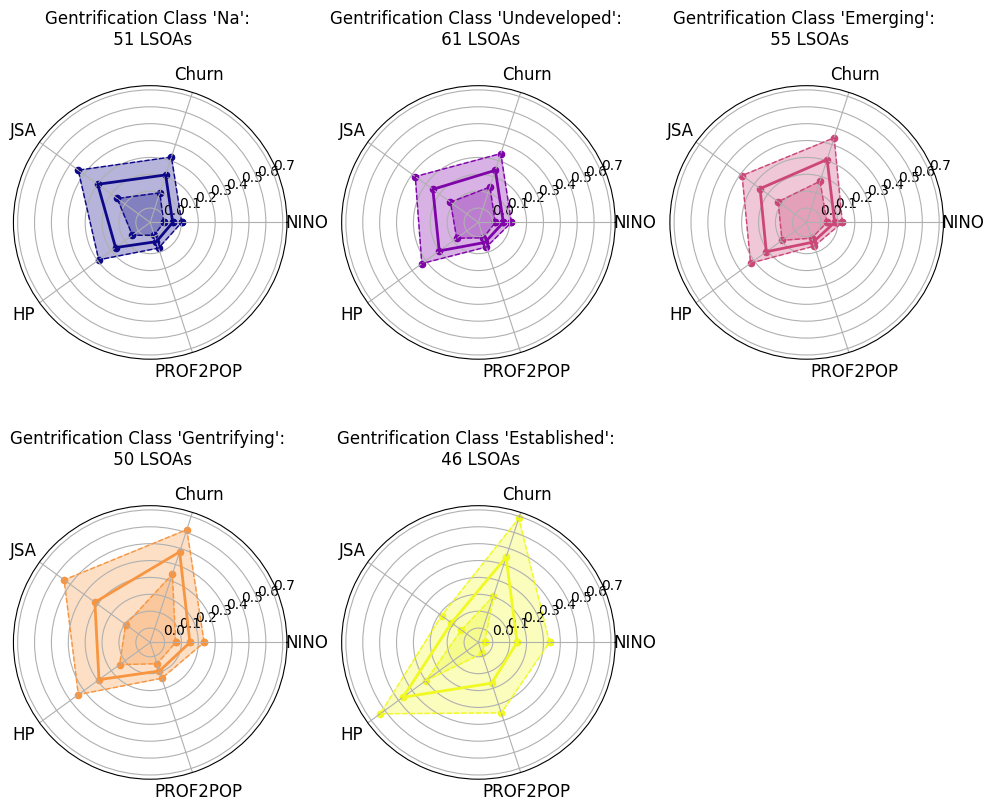

In [221]:
import numpy as np
import matplotlib.pyplot as plt

def plot_mean_rose_plot(ax, indicators, color):
    variables = ['NINO', 'Churn', 'JSA', 'HP', 'PROF2POP']
    means = [float(indicators['NINO_mean'].mean()), float(indicators['Churn_mean'].mean()), float(indicators['JSA_mean'].mean()), 
             float(indicators['HP_mean'].mean()), float(indicators['PROF2POP_mean'].mean())]

    std_devs = [float(indicators['NINO_mean'].std()), float(indicators['Churn_mean'].std()), float(indicators['JSA_mean'].std()), 
                float(indicators['HP_mean'].std()), float(indicators['PROF2POP_mean'].std())]
    # print("std lower:", std_lower)
    # print("std upper:", std_upper)
    
    num_vars = len(variables)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]
    means += means[:1]
    std_devs += std_devs[:1]

    # Calculate the upper and lower bounds for the std deviation
    # std_upper = np.array(means) + np.array(std_devs)
    # std_upper += std_upper[:1]
    # std_lower = np.array(means) - np.array(std_devs)
    # std_lower += std_lower[:1]

    
    std_upper = [mean + std for mean, std in zip(means, std_devs)]
    std_lower = [mean - std for mean, std in zip(means, std_devs)]

    
    
    
    # Plot the mean values
    ax.plot(angles, means, label='Mean', color=color, linewidth=2)
    ax.scatter(angles, means, color=color, s=20)
    
    # # Plot standard deviation above the mean (Mean + Std)
    ax.plot(angles, std_upper, label='Mean + Std', color=color, linestyle='--', linewidth=1)
    ax.scatter(angles, std_upper,  color=color, s=20)
    # Plot standard deviation below the mean (Mean - Std)
    
    ax.plot(angles, std_lower, label='Mean - Std', color=color, linestyle='--', linewidth=1)
    ax.scatter(angles, std_lower,  color=color, s=20)

    # # Fill the area between the mean and the upper standard deviation
    ax.fill(angles, std_upper, color=color, alpha=0.3)

    # # Fill the area between the mean and the lower standard deviation
    ax.fill(angles, std_lower, color=color, alpha=0.3)

    # # Add labels for each variable
    # ax.set_yticklabels([])  # Remove radial ticks
    ax.set_xticks(angles[:-1])  # Set the angular ticks
    ax.set_xticklabels(variables, fontsize=12)  # Set the variable labels

    # # Annotate mean and standard deviation values
    for i in range(num_vars):
        #ax.annotate(f'{means[i]:.2f}', (angles[i], means[i] + 0.2), color=color, fontsize=12, ha='center')
        #ax.annotate(f'{std_upper[i]:.2f}', (angles[i], std_upper[i] + 0.2), color='green', fontsize=12, ha='center')
        #ax.annotate(f'{std_lower[i]:.2f}', (angles[i], std_lower[i] - 0.2), color='red', fontsize=12, ha='center')
        print(f'{means[i]:.2f}, {std_upper[i]:.2f}, {std_lower[i]:.2f}')
    # Title and legend
    # ax.legend(loc='upper right', fontsize=10)

# Example usage for creating plots
fig, axs = plt.subplots(subplot_kw={'projection': 'polar'}, ncols=3, nrows=2, figsize=(12,10), sharex=True, sharey=True)

for gentr_class, ax in enumerate(axs.flatten()):
    class_data = indicators_bristol_short[indicators_bristol_short['gentrification_prediction_code'] == gentr_class]
    if len(class_data) == 0:
        ax.set_axis_off()
    else:
        plot_mean_rose_plot(ax, class_data, colors[gentr_class])
        key = [k for k, v in mapping.items() if v == gentr_class][0]
        ax.set_title(f"Gentrification Class '{key}': \n {len(class_data)} LSOAs", size=12, pad=30)

In [48]:
indicators_bristol_short = indicators_bristol.copy()

### PROF2POP
PROF2POP_cols = ['PROF2POP_2010', 'PROF2POP_2011', 'PROF2POP_2012', 'PROF2POP_2013','PROF2POP_2014', 'PROF2POP_2015'
                                                     , 'PROF2POP_2016', 'PROF2POP_2017','PROF2POP_2018', 'PROF2POP_2019', 'PROF2POP_2020']
indicators_bristol_short['PROF2POP_mean'] = indicators_bristol_short[PROF2POP_cols].mean(axis=1)
# indicators_bristol_short['PROF2POP_std'] = indicators_bristol_short[PROF2POP_cols].std(axis=1)

### CHURN
churn_cols = ['Churn_2008', 'Churn_2009', 'Churn_2010', 'Churn_2011','Churn_2012',  'Churn_2013', 'Churn_2014',
                                  'Churn_2015', 'Churn_2016', 'Churn_2017', 'Churn_2018', 'Churn_2019', 'Churn_2020']
indicators_bristol_short['Churn_mean'] = indicators_bristol_short[churn_cols].mean(axis=1)
# indicators_bristol_short['Churn_std'] = indicators_bristol_short[churn_cols].std(axis=1)

### NINO
nino_cols = ['NINO_2008', 'NINO_2009', 'NINO_2010', 'NINO_2011', 'NINO_2012','NINO_2013', 'NINO_2014', 
                                   'NINO_2015', 'NINO_2016', 'NINO_2017', 'NINO_2018', 'NINO_2019', 'NINO_2020']
indicators_bristol_short['NINO_mean'] = indicators_bristol_short[nino_cols].mean(axis=1)
# indicators_bristol_short['NINO_std'] = indicators_bristol_short[nino_cols].std(axis=1)

### JSA
jsa_cols = ['JSA_2008', 'JSA_2009', 'JSA_2010', 'JSA_2011', 'JSA_2012', 'JSA_2013', 'JSA_2014', 'JSA_2015',
                                    'JSA_2016', 'JSA_2017', 'JSA_2018', 'JSA_2019', 'JSA_2020']
indicators_bristol_short['jsa_mean'] = indicators_bristol_short[jsa_cols].mean(axis=1)
# indicators_bristol_short['jsa_std'] = indicators_bristol_short[jsa_cols].std(axis=1)

### HP
hp_cols = ['HP_2008', 'HP_2009', 'HP_2010', 'HP_2011', 'HP_2012', 'HP_2013', 'HP_2014',
                                     'HP_2015', 'HP_2016', 'HP_2017', 'HP_2018', 'HP_2019', 'HP_2020',]
# Calculate the mean for each row
indicators_bristol_short['hp_mean'] = indicators_bristol_short[hp_cols].mean(axis=1)
# indicators_bristol_short['hp_std'] = indicators_bristol_short[hp_cols].std(axis=1)

###
indicators_bristol_short.drop(hp_cols + churn_cols + nino_cols + PROF2POP_cols + jsa_cols, axis=1, inplace=True)

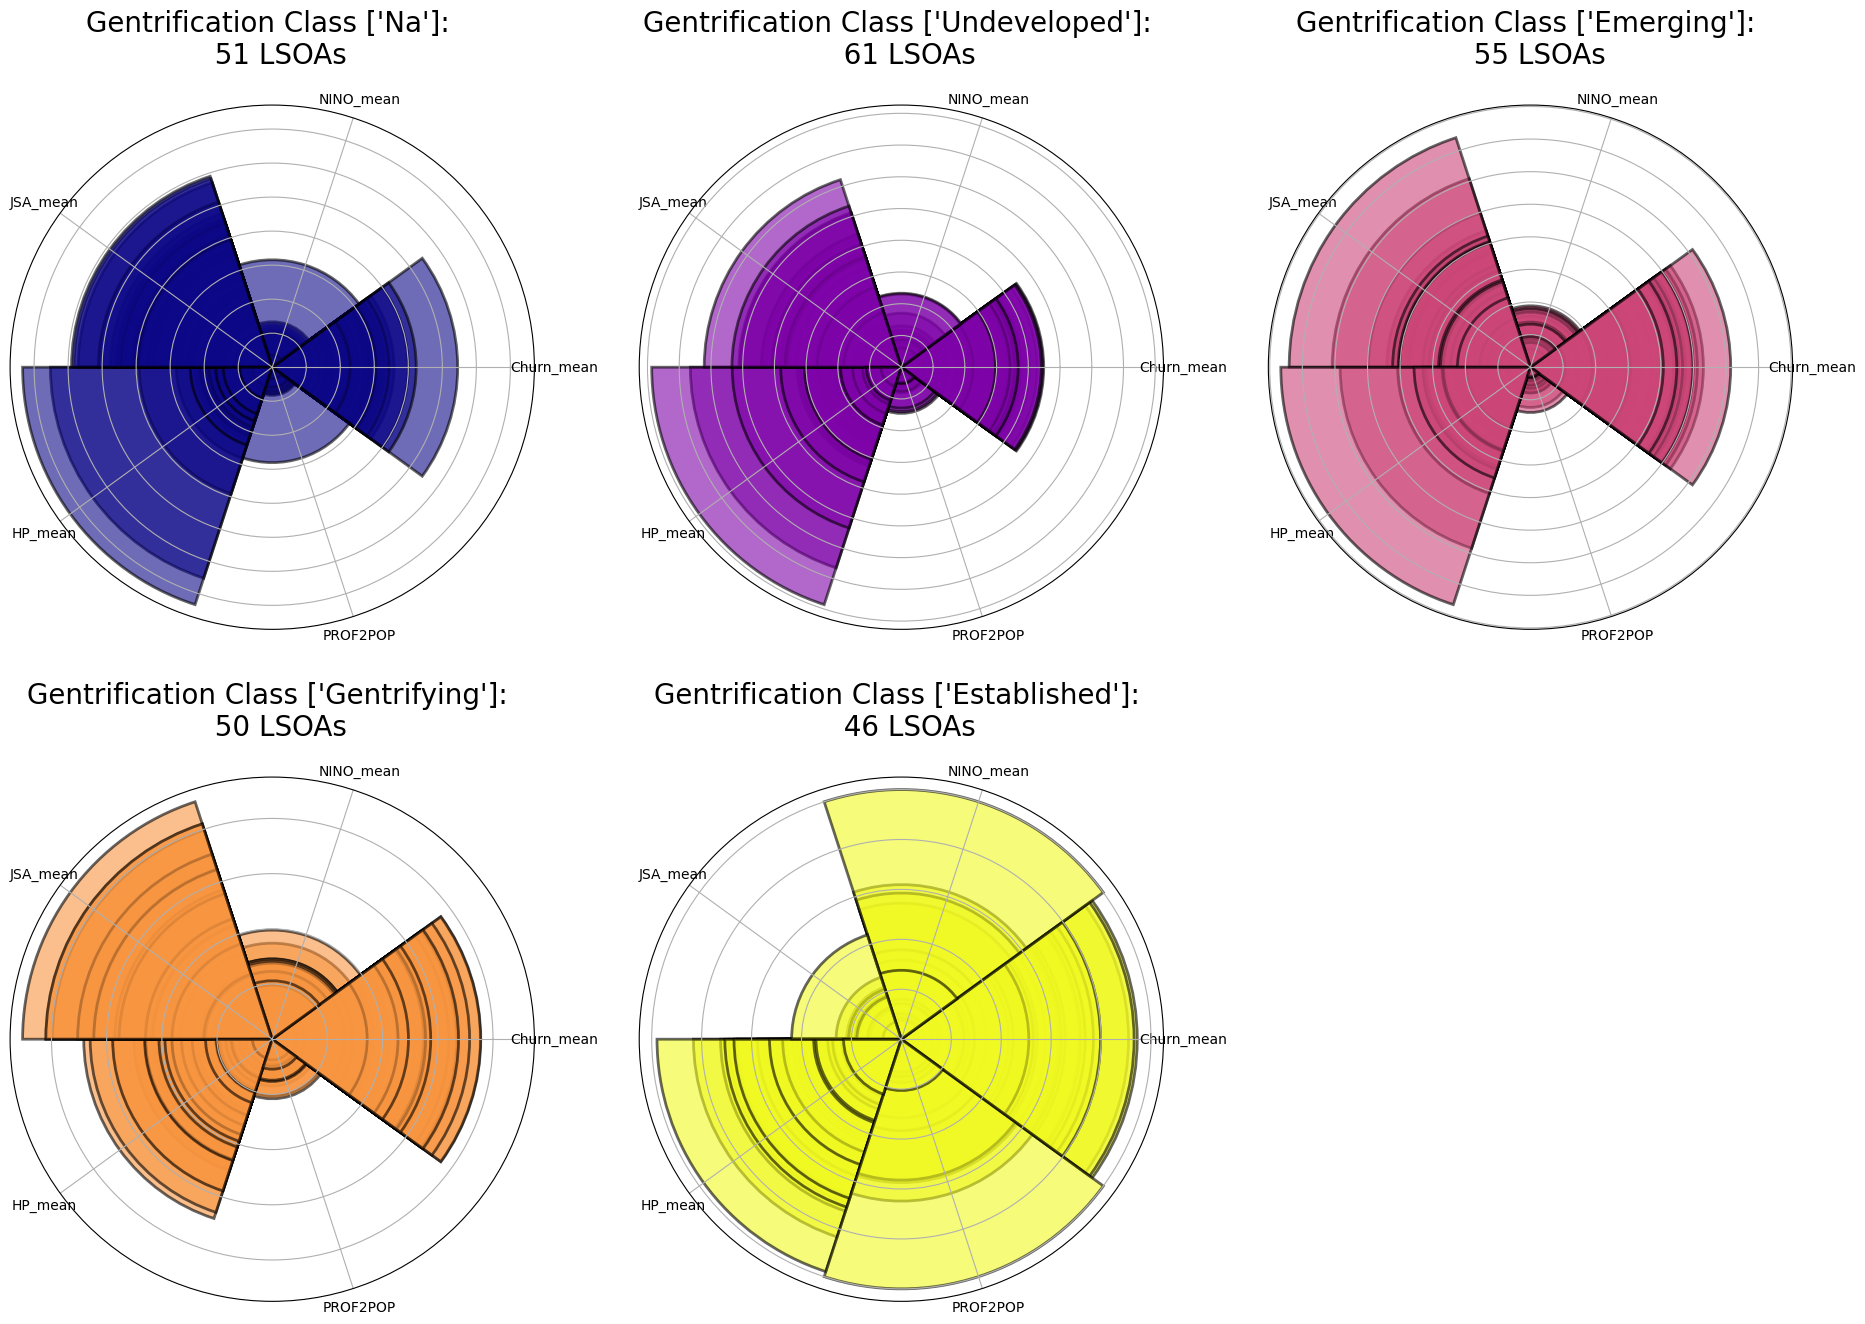

In [40]:
cmap = plt.get_cmap('plasma', 5)  # 5 discrete colors
colors = [cmap(i) for i in range(5)]

fig, axs = plt.subplots(subplot_kw={'projection': 'polar'}, ncols=3, nrows=2, figsize=(23,16))
for gentr_class, ax in enumerate(axs.flatten()):
    # Filter the data for this gentrification class
    class_data = indicators_bristol_short[indicators_bristol_short['gentrification_prediction_code'] == gentr_class]
    if len(class_data) == 0:
        ax.set_axis_off()
    else:    
        for lsoa in class_data['LSOA11CD']:
            plot_rose(ax,indicators_bristol_short, lsoa, colors[gentr_class])
        key = [k for k, v in mapping.items() if v == gentr_class]
        ax.set_title(f"Gentrification Class {key}: \n  {len(class_data)} LSOAs", pad=30, fontsize=20)  

### Plot for one LSOA

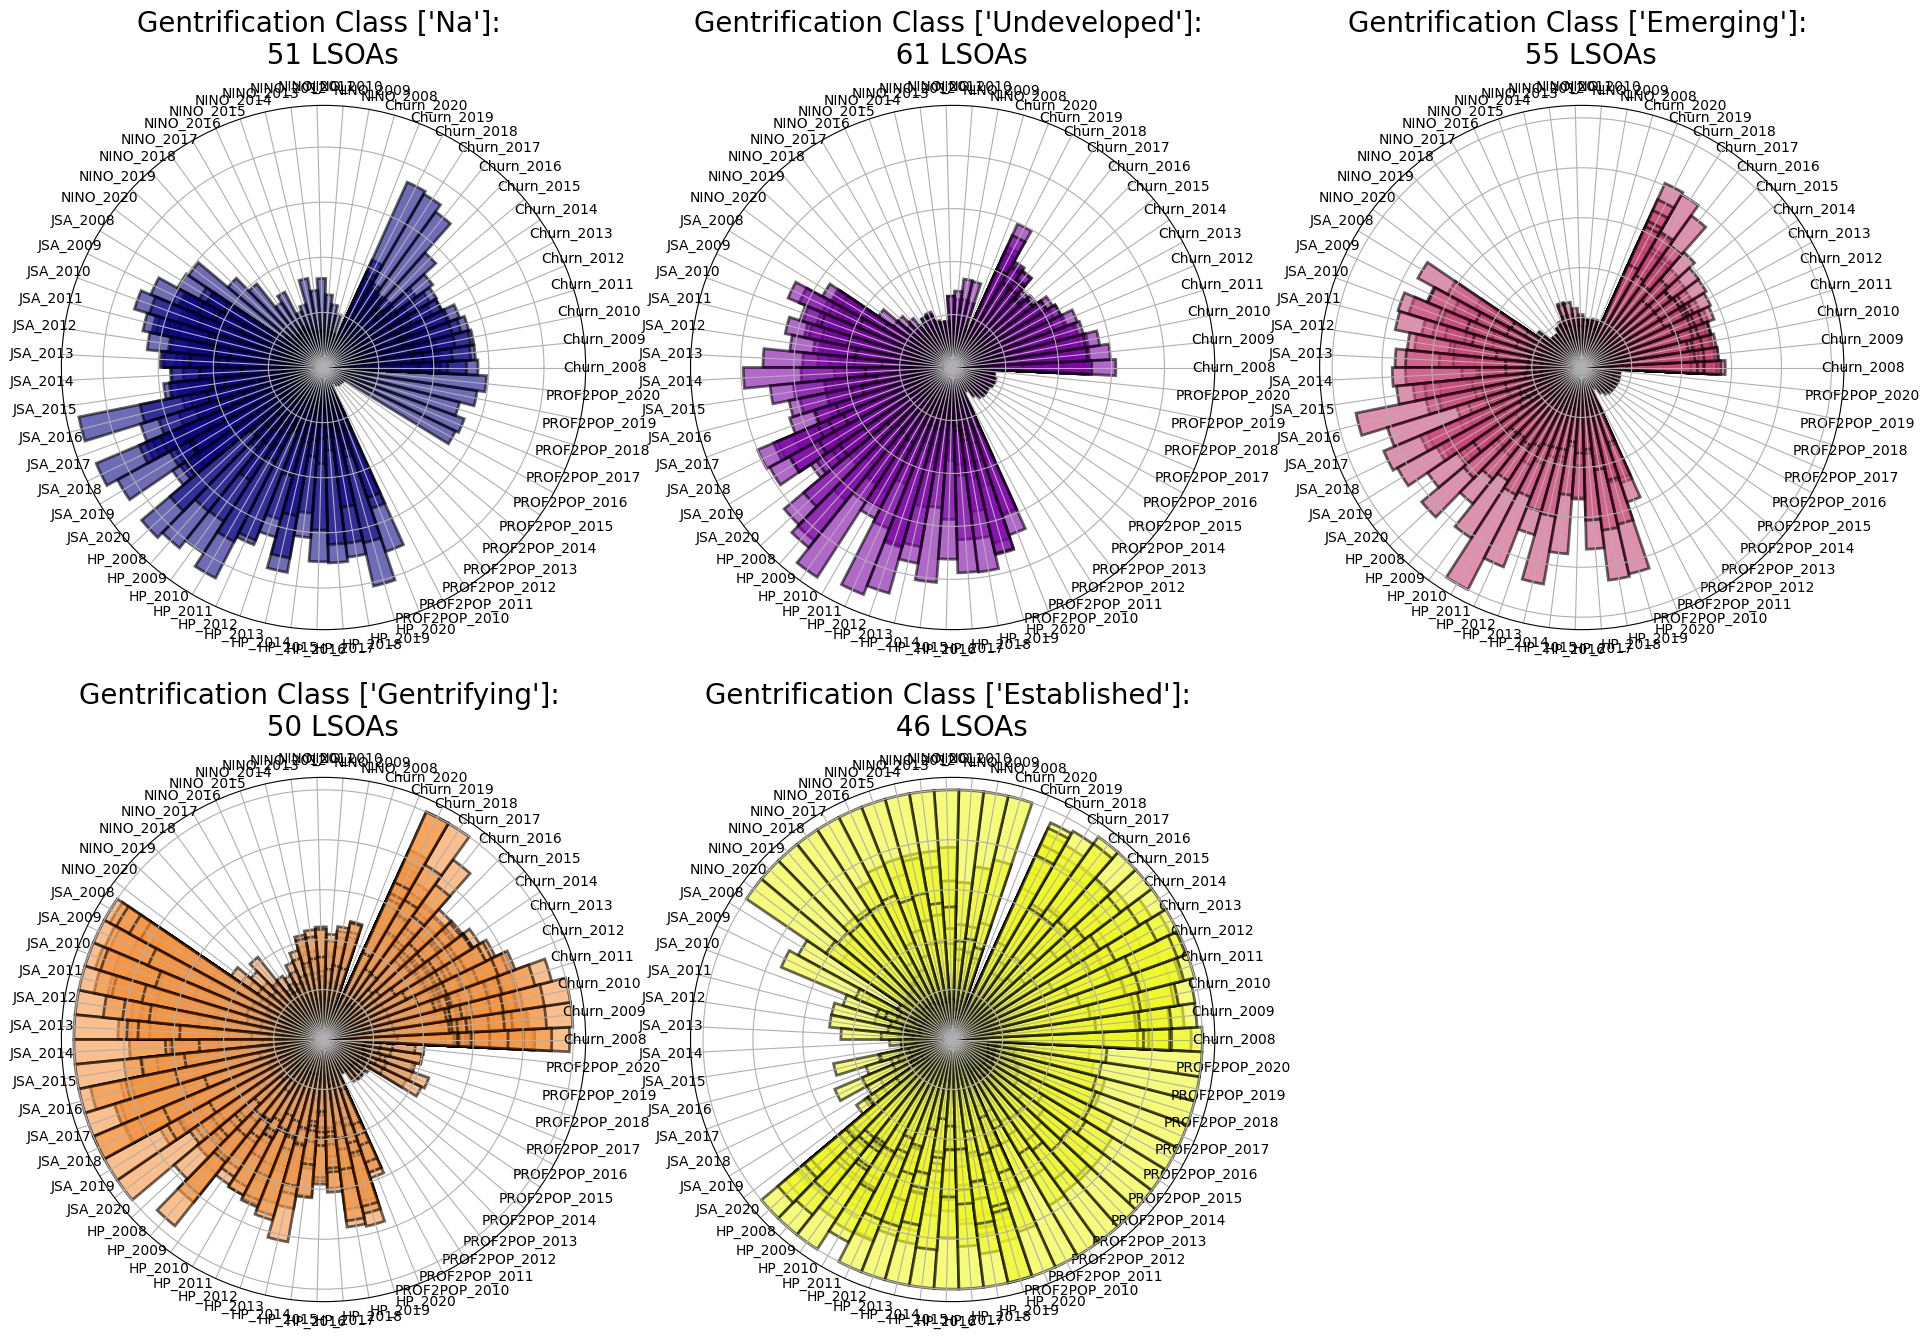

In [246]:
cmap = plt.get_cmap('plasma', 5)  # 5 discrete colors
colors = [cmap(i) for i in range(5)]

fig, axs = plt.subplots(subplot_kw={'projection': 'polar'}, ncols=3, nrows=2, figsize=(23,16))
for gentr_class, ax in enumerate(axs.flatten()):
    # Filter the data for this gentrification class
    class_data = indicators_bristol[indicators_bristol['gentrification_prediction_code'] == gentr_class]
    if len(class_data) == 0:
        ax.set_axis_off()
    else:    
        for lsoa in class_data['LSOA11CD']:
            plot_rose(ax, lsoa, colors[gentr_class])
        key = [k for k, v in mapping.items() if v == gentr_class]
        ax.set_title(f"Gentrification Class {key}: \n  {len(class_data)} LSOAs", pad=30, fontsize=20)  

## Map the scores, colouring by gentrification prediction

In [18]:
# moving_map = map_not_static(neighbourhoods, overall_df, 'gentrification_prediction_code', True)
# display(moving_map)

In [76]:
# moving_map = map_not_static(neighbourhoods, overall_df, 'gentrification_prediction', True)
# display(moving_map)

### Look at correlation between listing length and score

In [ ]:
make_scatter_plot(df, 'overview_length')

In [ ]:
make_scatter_plot(df, 'price_relative')

In [124]:
import pandas as pd
from textblob import TextBlob
import re

# Define weighted keywords
keyword_map = {
    # High Gentrification Indicators (+3)
    "up-and-coming": 3, "revitalized": 3, "urban renewal": 3, "trendy": 3,
    "boutique stores": 3, "artisan coffee": 3, "craft brewery": 3, 
    "farm-to-table": 3, "luxury loft": 3, "co-working spaces": 3, "renovated": 3,

    # Moderate Gentrification Indicators (+2)
    "cultural hub": 2, "hip": 2, "eco-conscious": 2, "vibrant art scene": 2,
    "independent shops": 2, "local farmers market": 2, "food trucks": 2, 
    "community events": 2, "pop-up shops": 2, "speakeasy": 2, "converted warehouse": 2,

    # Subtle/Early Indicators (+1)
    "authentic": 1, "diverse": 1, "hidden gem": 1, "off the beaten path": 1,
    "family-friendly": 1, "walkable": 1, "green spaces": 1, "pet-friendly": 1,
    "friendly neighbors": 1, "historic charm": 1, "safe neighborhood": 1
}

def analyze_listing(text):
    text=str(text)
    # Handle NaN or non-string inputs
    if not isinstance(text, str):
        print("not text")
        return pd.Series([0, 0, 0, []])  # No score, neutral sentiment, empty keyword list

    text_lower = text.lower()
    score = 0
    keywords_found = []

    # Check for keywords
    for keyword, weight in keyword_map.items():
        if re.search(r'\b' + re.escape(keyword) + r'\b', text_lower):
            score += weight
            keywords_found.append(keyword)
    print(keywords_found)
    # Sentiment Analysis
    sentiment = TextBlob(text).sentiment.polarity  # Range from -1 to 1
    sentiment_modifier = 1 if sentiment > 0 else -1 if sentiment < 0 else 0
    adjusted_score = score + sentiment_modifier

    return pd.Series([score, sentiment, adjusted_score, keywords_found])

# Apply analysis to DataFrame
overall_df[['Keyword_Score', 'Sentiment', 'Final_Score', 'Keywords_Found']] = overall_df['text'].apply(analyze_listing)



[]
[]
['hip', 'independent shops', 'green spaces']
['green spaces']
[]
['independent shops']
[]
[]
[]
[]
[]
[]
[]
[]
['independent shops', 'family-friendly']
[]
[]
[]
[]
[]
[]
[]
['independent shops']
[]
[]
['cultural hub']
['hip', 'authentic']
[]
[]
['independent shops']
['independent shops']
['trendy', 'diverse', 'green spaces']
[]
[]
['diverse']
[]
[]
['diverse']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['diverse']
[]
[]
[]
[]
['trendy', 'independent shops']
['independent shops']
[]
[]
['independent shops']
['community events']
[]
['independent shops']
[]
[]
[]
[]
[]
[]
[]
['independent shops']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['independent shops']
['trendy']
[]
[]
[]
[]
['diverse']
[]
[]
['independent shops']
[]
[]
[]
[]
['independent shops']
[]
[]
[]
[]
[]
[]
['independent shops']
[]
[]
[]
[]
[]
['hip']
[]
[]
[]
['renovated']
[]
[]
[]
[]
[]
[]
['independent shops']
[]
[]
[]
[]
[]
['independent shops']
[]
[]
[]
[]
[]
['independent shops']
[]
[]
[]
[]
['independent shops', 'green spaces']
[